# Notebook to load clustering results and compare them to reference SEDs (such as CWW-Kinney in LePhare)

Created on : Feb. 6, 2023 by Joseph Chevalier

Last update : Feb. 14, 2023 by Joseph Chevalier

## Imports and settings

In [1]:
import os, sys, re
import pickle
import json
import glob
import collections

import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.offsetbox
from matplotlib.backends.backend_pdf import PdfPages
%matplotlib inline
# to enlarge the sizes
params = {'legend.fontsize': 'large',
          'figure.figsize': (12, 8),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
plt.rcParams.update(params)
props = dict(boxstyle='round',edgecolor="w",facecolor="w", alpha=0.5)

from itertools import cycle, islice

from astropy.io import fits
from astropy.table import Table
from scipy import ndimage
from scipy.interpolate import interp1d

# Import the primary photometry classes from rubin_sim.photUtils
from rubin_sim.phot_utils import Bandpass
from rubin_sim.phot_utils import Sed
from rubin_sim.data import get_data_dir
from StudyFors2SED.def_raw_seds import *
#from StudyFors2SED.raw_data_analysis import *

pysynphot_root_path=os.environ['PYSYN_CDBS']
path_sed_calspec=os.path.join(pysynphot_root_path,'calspec')
# pysynphot
import pysynphot as S
S.refs.setref(area=1)
S.refs.getref()

{'graphtable': '/home/joseph/local/dir/trds/mtab/57g1733im_tmg.fits',
 'comptable': '/home/joseph/local/dir/trds/mtab/6452249tm_tmc.fits',
 'thermtable': '/home/joseph/local/dir/trds/mtab/3241637sm_tmt.fits',
 'area': 1,
 'waveset': 'Min: 500, Max: 26000, Num: 10000, Delta: None, Log: True'}

In [2]:
def SaveImageInPdf(all_figs,outputfile):
    """
    """
    with PdfPages(outputfile) as pdf:
        for fig in all_figs:
            pdf.savefig(fig)
            plt.close()

In [3]:
root_dir, base_name = os.path.split(os.getcwd())
print(root_dir)

/home/joseph


In [4]:
os.listdir(root_dir)

['.python_history',
 '.condarc',
 'AuxtelEnv',
 'pylick',
 'rubin_sim',
 'rubin_sim_data',
 '.stackyter-config.yaml',
 '.landscape',
 '.sudo_as_admin_successful',
 '.gitconfig',
 'Downloads',
 '.conda',
 'PhotoZEnv',
 '.cache',
 '.bash_history',
 '.nedit',
 'anaconda3',
 'datasets-fidle',
 '.wget-hsts',
 '.keras',
 'Spectractor',
 '.motd_shown',
 '.config',
 'CosmoOfDarkUniverse',
 '.astropy',
 'Anaconda3-2022.10-Linux-x86_64.sh',
 'python311',
 'delegate-contributions-dp02',
 'StackyterEnv',
 'RAIL',
 'WIP_FORS2',
 'computerScienceTrainings_IJClab2023',
 '.profile',
 '._data',
 'fidle-master',
 '.jupyter',
 '.ssh',
 '.ipynb_checkpoints',
 '.bash_logout',
 'GMAOMERRA2',
 '.viminfo',
 'Strava_stuff',
 '.bashrc',
 '.bash_aliases',
 '.mozilla',
 'AuxTelComm',
 '.local',
 'libRadtran',
 'lephare_cosmos',
 'AuxTel_eqw',
 'PhotoZ_PhD',
 'snap',
 'Polar_stuff',
 'local',
 '.ipython',
 '.dbus']

In [5]:
filename_fits_catalog
t = Table.read(filename_fits_catalog)
t[t["ID"]==106]['z'][0]

0.6436

In [6]:
print(path_BC)
spec_list = sorted(os.listdir(path_BC))

/home/joseph/PhotoZ_PhD//ResStarlight/BC03N/conf1/HZ4/output_rebuild_BC/full_spectra/


In [7]:
all_numbers = [ int(re.findall('^SPEC(.*)_HZ4_BC[.]txt$',fn)[0]) for fn in spec_list ]
all_numbers = sorted(all_numbers)

## Load LEPHARE results

In [8]:
lephare_res_dir = 'lephare_cosmos'
if os.getenv('LEPHAREWORK') is not None:
    lephare_res_path = os.environ['LEPHAREWORK']
else:
    lephare_res_path = os.path.abspath(os.path.join(os.getcwd(),lephare_res_dir))
    os.environ['LEPHAREWORK'] = lephare_res_path

lephare_dir = 'LEPHARE'
if os.getenv('LEPHAREDIR') is not None:
    LEPHAREDIR = os.environ['LEPHAREDIR']
else:
    LEPHAREDIR = os.path.abspath(os.path.join(os.getcwd(),lephare_dir))
    os.environ['LEPHAREDIR'] = LEPHAREDIR

In [9]:
sorted(os.listdir(os.environ['LEPHAREWORK']))

['.git',
 '.gitignore',
 '.gitmodules',
 '.ipynb_checkpoints',
 '2020-05-28_eric_commands_full_cosmos.dat',
 'BC03_ASCII.list',
 'Biblio',
 'CFHTLS_230506',
 'COSMOS2020.R1_v2.1',
 'COSMOS2020.in',
 'COSMOS2020.para',
 'COSMOS2020_EmuLP.para',
 'COSMOS2020_emu_hscOnly_CC_lp_fmt.in',
 'FORS2_forFixedZ_CWW-E_v1.list',
 'FORS2_forFixedZ_CWW-E_v1_normed.list',
 'FORS2_forFixedZ_CWW-Im_v1.list',
 'FORS2_forFixedZ_CWW-Im_v1_normed.list',
 'FORS2_forFixedZ_CWW-Sbc_v1.list',
 'FORS2_forFixedZ_CWW-Sbc_v1_normed.list',
 'FORS2_forFixedZ_CWW-Scd_v1.list',
 'FORS2_forFixedZ_CWW-Scd_v1_normed.list',
 'LIB2020_FORS2_SL_DustySelV1_EmuLP.out',
 'README.md',
 'SCOSMOS.para',
 'SED_AVG_FORS2.list',
 'SED_AVG_FORS2_normed.list',
 'SED_AVG_fromSL_FORS2_normed.list',
 'SED_FORS2_ColorSelect_SL_v1.list',
 'SED_FORS2_ColorSelect_SL_v1_normed.list',
 'SED_FORS2_ColorSelect_SL_v2.list',
 'SED_FORS2_ColorSelect_SL_v2_normed.list',
 'SED_FORS2_ColorSelect_SL_v3.list',
 'SED_FORS2_ColorSelect_SL_v3_normed.list',


In [10]:
########
# PARAMETERS TO SET

# Number of the filter start at 0
selFilt=5   # filter for the selection in mag
uFilt=0
bFilt=2
rFilt=3
zFilt=5
jFilt=8
KsFilt=10

# Array in redshift and mag, isolate extreme values
range_z = np.arange(0., 6.2, 0.5) #[0,1,2,3,6]
z_min, z_max = np.amin(range_z), np.amax(range_z)
range_mag = [15.,22.5,23.5,25,28]
mag_min, mag_max = np.amin(range_mag), np.amax(range_mag)

In [11]:
##################################################
#    CONDITION FOR SELECTION

# Mag use to select the sample
#mag=eval("mag"+str(selFilt))

# condition to select stars
#condstar = (chis<chi)

# condition to select galaxies
#condgal = (~condstar)

def figlpz_zp_zs(zs, zp, mag, runLabel="DUM", magmin=mag_min, magmax=mag_max):
    # General condition to select the galaxies in the expected z/mag range
    cond = (zp>z_min) & (zp<z_max) & (mag>mag_min) & (mag<mag_max)
    
    # condition to select spectroscopic redshifts
    condspec = (zs>0) & (zs<9)
    
    #set the axis
    plt.axis([z_min,z_max,z_min,z_max])

    #new condition with the magnitude range 
    condA = cond & condspec & (mag>magmin) & (mag<magmax)

    # Plot photo-z versus spec-z
    plt.scatter(zs[condA], zp[condA], s=1, color='b',alpha=0.5,marker='s')

    #Check that we have some sources before performing statistics
    Ngal = len( zp[condA])
    if Ngal > 0 :
        #statistics
        arg_bias = zp[condA]-zs[condA]
        arg_std = arg_bias / (1. + zs[condA])
        NMAD = 1.4821 * np.median( abs(arg_std))
        cond_outl = ( abs(arg_std) > 0.15 )
        outl_rate = len(arg_std[cond_outl]) / float(Ngal)
        plt.annotate(r'$N_{gal}  = '+str(Ngal)+'$ \n'+'$\eta  ='+str(100*round(outl_rate,3))+'  \%$\n'+'$ \sigma_{\Delta z /(1+z)}  = '+str(round(NMAD,5))+'$',xy=(0.1*z_max,0.8*z_max),color="black", fontsize=15)

    #Trace the limits 0.15(1+z)
    x_zs = np.array([0,6])
    plt.plot(x_zs, x_zs*1.15+0.15, 'c--')
    plt.plot(x_zs, x_zs, 'r-')
    plt.plot(x_zs, x_zs*0.85-0.15, 'c--')

    #labels
    plt.title("$"+runLabel+"\ run - "+str(mag_min)+" < mag < "+str(mag_max)+"$")
    plt.xlabel('$z_{spec}$', fontsize=18, labelpad=13)
    plt.ylabel('$z_{phot} \; minimum \; \chi^2$', fontsize=18, labelpad=13)

In [12]:
# Loop over the filters
nbFilt=7
magst=""
idmagst=""
# create the string to read the mag
for i in range(nbFilt) :
    magst=magst+",mag"+str(i)
    idmagst=idmagst+","+str(i+20)
# create the string to read the error mag
for i in range(nbFilt) :
    magst=magst+",emag"+str(i)
    idmagst=idmagst+","+str(i+20+nbFilt)
# create the string to read the absolute mag
for i in range(nbFilt) :
    magst=magst+",absmag"+str(i)
    idmagst=idmagst+","+str(i+20+3*nbFilt)
# create the string to read the uncertainties on absolute mag
for i in range(nbFilt) :
    magst=magst+",eabsmag"+str(i)
    idmagst=idmagst+","+str(i+20+4*nbFilt)


# Extract from the ascii file
commandst = "Id,zp,zl68,zu68,zml,zmll68,zmlu68,chi,mod,law,ebv,zp2,chi2,mod2,ebv2,zq,chiq,modq,mods,chis"+magst+",scale,nbFilt,context,zs = np.loadtxt(res_file_path, dtype='float', usecols=(0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19"+idmagst+",62,63,64,65), unpack=True )"
# transform the string into a command
print(commandst)

Id,zp,zl68,zu68,zml,zmll68,zmlu68,chi,mod,law,ebv,zp2,chi2,mod2,ebv2,zq,chiq,modq,mods,chis,mag0,mag1,mag2,mag3,mag4,mag5,mag6,emag0,emag1,emag2,emag3,emag4,emag5,emag6,absmag0,absmag1,absmag2,absmag3,absmag4,absmag5,absmag6,eabsmag0,eabsmag1,eabsmag2,eabsmag3,eabsmag4,eabsmag5,eabsmag6,scale,nbFilt,context,zs = np.loadtxt(res_file_path, dtype='float', usecols=(0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,41,42,43,44,45,46,47,48,49,50,51,52,53,54,62,63,64,65), unpack=True )


In [13]:
#res_file_name, templates_list  = 'zphot2020_fors2SL_FixedZ_CWW-E_v1_noExt.out', 'FORS2_forFixedZ_CWW-E_v1.list'

#res_file_name, templates_list  = 'zphot2020_fors2SL_KinCalClusV6_noAVG_prevEtCal_zfix.out', 'SED_FORS2_KinCalClus_SL_v6_noAVG.list'
res_file_name, templates_list  = 'zphot2020_vista_adapt_EmuLP_CWWtemp_zfix.out', 'CFHTLS_230506/CFHTLS_MOD.list'

res_file_name, templates_list  = 'zphot2020_fors2DSPS_noDustV1_prevEtCal_EmuLP_zfix.out', 'SED_FORS2_DSPS_noDust_v1.list'

res_file_path = os.path.join(lephare_res_path, res_file_name)
list_seds_path = os.path.join(lephare_res_path, templates_list)
#list_seds_path = os.path.join(LEPHAREDIR, 'sed', 'GAL', templates_list)

In [14]:
if False:
    with open(res_file_path, 'r') as file:
        print(file.readlines()[30:51])

In [15]:
with open(list_seds_path,'r') as _f:
    _seds_list = _f.readlines()[1:]
paths_to_fors2seds = [os.path.join(LEPHAREDIR, 'sed/GAL', _sed.split(" ")[0][:-1]) for _sed in _seds_list]
#paths_to_fors2seds

#fors2seds_ids = [ (_p.split('/')[-1]).split('_')[0] for _p in paths_to_fors2seds]
fors2seds_ids = [ '.'.join((_p.split('/')[-1]).split('.')[:-1]) for _p in paths_to_fors2seds]
N_seds = len(fors2seds_ids)
fors2seds_ids

['SPEC226_DSPS_noDust',
 'SPEC227_DSPS_noDust',
 'SPEC451_DSPS_noDust',
 'SPEC714_DSPS_noDust',
 'SPEC496_DSPS_noDust',
 'SPEC589_DSPS_noDust',
 'SPEC282_DSPS_noDust',
 'SPEC235_DSPS_noDust',
 'SPEC87_DSPS_noDust',
 'SPEC107_DSPS_noDust',
 'SPEC113_DSPS_noDust',
 'SPEC114_DSPS_noDust',
 'SPEC265_DSPS_noDust',
 'SPEC537_DSPS_noDust',
 'SPEC546_DSPS_noDust',
 'SPEC344_DSPS_noDust',
 'SPEC699_DSPS_noDust',
 'SPEC45_DSPS_noDust',
 'SPEC268_DSPS_noDust',
 'SPEC291_DSPS_noDust',
 'SPEC354_DSPS_noDust',
 'SPEC639_DSPS_noDust',
 'SPEC532_DSPS_noDust',
 'SPEC585_DSPS_noDust']

In [16]:
exec(commandst)

In [17]:
cols_df = commandst.split(' = ')[0]
idx_df, cols_df = cols_df.split(',')[0], cols_df.split(',')[1:]
idx_df

'Id'

In [18]:
np.array(eval(idx_df), dtype='int')

array([  362,  8353,  7547, 10402, 12425, 15894,  6567, 12932, 10103,
        1756,  4477,  9046,  6655,  3391,  1846,  6568,  1151, 16375,
       12199,  9779,  5992, 16989, 10580, 15991, 15046,   306,   316,
        4457, 11933,  7309,  3497, 11765, 13852,  2908,  7135, 16521,
        8404,  9739,  5303,  9697, 12071, 15464, 16793,  3918, 12392,
       14353,   957,  4027,  7580, 11532, 13017,  2961, 17251,  8479,
       16631,  6096, 10077,  9843, 10992,  3802,  4661,  1515, 13085,
       17291,  2151, 11710, 17178,  9432, 16724, 17094, 11821, 10288,
         508, 13038,  2910, 12978,  1483,   366, 17847,  7480,  3104,
       16688, 15690, 17784, 14745,  1469,  1474,  9622, 17633,  5705,
        9809, 16406, 17096, 17876,  5552, 17717, 11709,  8506,  4840,
       11148,  5637,  6101,  6364, 10257, 15794,  2071, 13461, 14221,
        1634,  8282,  2832,  2506,  4588, 16242, 11518, 12531,  5619,
        1917, 14029,    73,  6819,  8043,  5532,  6947, 18259,  8456,
       13549, 15715,

In [19]:
_df_resLePhare = pd.DataFrame()
_df_resLePhare['Id'] = np.array(eval(idx_df), dtype='int')
for col in cols_df:
    _df_resLePhare[col] = eval(col)
_df_resLePhare['mod']

0      22.0
1      22.0
2      22.0
3      21.0
4      22.0
       ... 
995    22.0
996    17.0
997    21.0
998    22.0
999    22.0
Name: mod, Length: 1000, dtype: float64

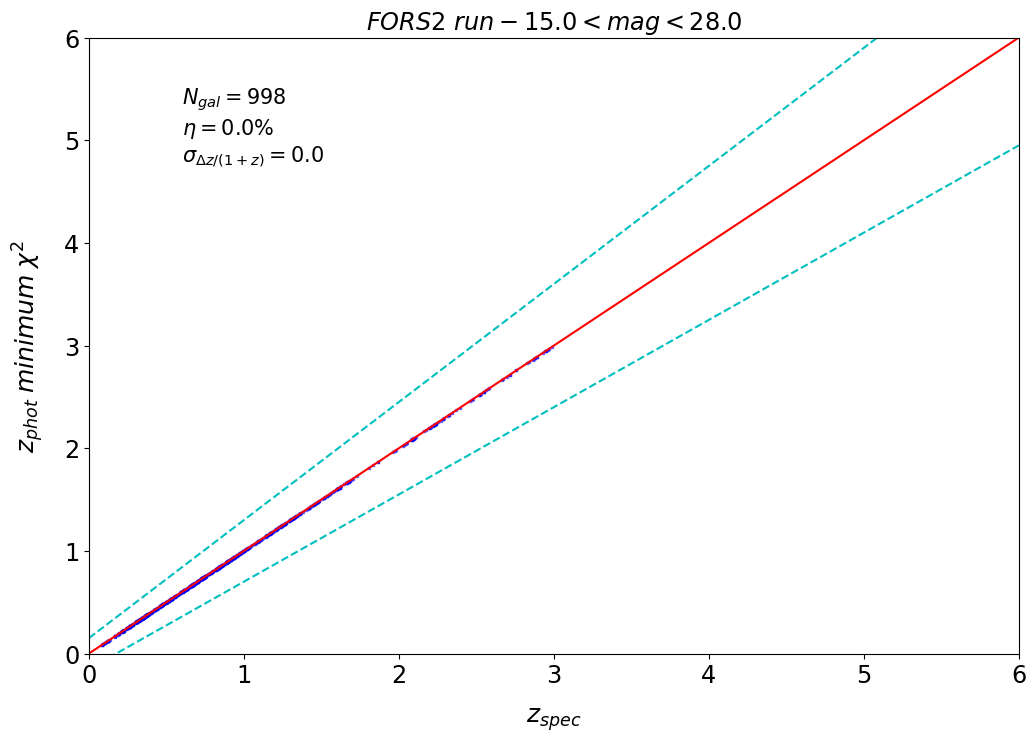

In [20]:
figlpz_zp_zs(_df_resLePhare['zs'], _df_resLePhare['zp'], _df_resLePhare["mag"+str(selFilt)],\
             runLabel='FORS2', magmin=mag_min, magmax=mag_max)

### Redshifts along the diagonal shows good behaviour of ZFIX option in LEPHARE

In [21]:
mod_paths=[]
mod_ids=[]
for m in _df_resLePhare['mod']:
    if m<0 :
        mod_paths.append("")
        mod_ids.append("")
    elif m <= N_seds:
        mod_paths.append(paths_to_fors2seds[int(m)-1])
        mod_ids.append(fors2seds_ids[int(m)-1])
    else :
        mod_paths.append(paths_to_fors2seds[int(m-N_seds)-1])
        mod_ids.append(fors2seds_ids[int(m-N_seds)-1])
_df_resLePhare['Path to mod'] = mod_paths
_df_resLePhare['mod id'] = mod_ids

_sel_mod2 = (_df_resLePhare['mod2'] >= 0)
_df_resLePhare.loc[_df_resLePhare.index[_sel_mod2], 'Path to mod2'] = [paths_to_fors2seds[int(m)-1] if (m <= N_seds) else paths_to_fors2seds[int(m-N_seds)-1] for m in _df_resLePhare['mod2'][_sel_mod2]]
_df_resLePhare.loc[_df_resLePhare.index[_sel_mod2], 'mod2 id'] = [fors2seds_ids[int(m)-1] if (m > 0) and (m <= N_seds) else fors2seds_ids[int(m-N_seds)-1] for m in _df_resLePhare['mod2'][_sel_mod2]]
_df_resLePhare.fillna(value={'Path to mod2':'n/a',\
                             'mod2 id':'n/a'},\
                      inplace=True)

In [22]:
for gal in _df_resLePhare.index:
    _sel = _df_resLePhare.loc[gal, f'mag{selFilt}']
    if _sel < mag_min:
        _df_resLePhare.loc[gal, 'SEL_MAG'] = f'mag<{mag_min}'
    elif _sel >= mag_max:
        _df_resLePhare.loc[gal, 'SEL_MAG'] = f'{mag_max}<=mag'
    else:
        for m,M in zip(range_mag[:-1], range_mag[1:]):
            if _sel >= m and _sel < M :
                _df_resLePhare.loc[gal, 'SEL_MAG'] = f'{m}<=mag<{M}'

In [23]:
for gal in _df_resLePhare.index:
    _sel = _df_resLePhare.loc[gal, 'zs']
    if _sel < z_min:
        _df_resLePhare.loc[gal, 'SEL_ZS'] = f'z-spec<{z_min}'
    elif _sel >= z_max:
        _df_resLePhare.loc[gal, 'SEL_ZS'] = f'{z_max}<=z-spec'
    else:
        for z,Z in zip(range_z[:-1], range_z[1:]):
            if _sel >= z and _sel < Z :
                _df_resLePhare.loc[gal, 'SEL_ZS'] = f'{z}<=z-spec<{Z}'

## Save dataframe as pickle

In [24]:
df_resLePhare = _df_resLePhare.copy()
if True: df_resLePhare.to_pickle('df_'+res_file_name.split('.')[0]+'.pkl')
df_resLePhare

,Id,zp,zl68,zu68,zml,zmll68,zmlu68,chi,mod,law,...,scale,nbFilt,context,zs,Path to mod,mod id,Path to mod2,mod2 id,SEL_MAG,SEL_ZS
0,362,0.6636,0.66,0.66,0.66,0.6532,0.6668,69.73750,22.0,0.0,...,31.18660,7.0,0.0,0.6636,/home/joseph/PhotoZ_PhD/LEPHARE/sed/GAL/FORS2_...,SPEC639_DSPS_noDust,n/a,n/a,15.0<=mag<22.5,0.5<=z-spec<1.0
1,8353,0.2819,0.28,0.28,0.28,0.2732,0.2868,7.24336,22.0,0.0,...,58.02010,7.0,0.0,0.2819,/home/joseph/PhotoZ_PhD/LEPHARE/sed/GAL/FORS2_...,SPEC639_DSPS_noDust,n/a,n/a,15.0<=mag<22.5,0.0<=z-spec<0.5
2,7547,0.2215,0.22,0.22,0.22,0.2132,0.2268,29.38850,22.0,0.0,...,7.91476,7.0,0.0,0.2215,/home/joseph/PhotoZ_PhD/LEPHARE/sed/GAL/FORS2_...,SPEC639_DSPS_noDust,n/a,n/a,15.0<=mag<22.5,0.0<=z-spec<0.5
3,10402,0.6595,0.66,0.66,0.66,0.6532,0.6668,18.39740,21.0,1.0,...,83.70940,7.0,0.0,0.6595,/home/joseph/PhotoZ_PhD/LEPHARE/sed/GAL/FORS2_...,SPEC354_DSPS_noDust,n/a,n/a,15.0<=mag<22.5,0.5<=z-spec<1.0
4,12425,1.0200,1.02,1.02,1.02,1.0132,1.0268,89.17320,22.0,1.0,...,55.23120,7.0,0.0,1.0201,/home/joseph/PhotoZ_PhD/LEPHARE/sed/GAL/FORS2_...,SPEC639_DSPS_noDust,n/a,n/a,22.5<=mag<23.5,1.0<=z-spec<1.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,5756,2.6640,2.66,2.66,2.66,2.6532,2.6668,22.88850,22.0,1.0,...,313.22900,7.0,0.0,2.6639,/home/joseph/PhotoZ_PhD/LEPHARE/sed/GAL/FORS2_...,SPEC639_DSPS_noDust,n/a,n/a,23.5<=mag<25,2.5<=z-spec<3.0
996,16455,0.7336,0.73,0.73,0.73,0.7232,0.7368,29.19320,17.0,1.0,...,84.56080,7.0,0.0,0.7336,/home/joseph/PhotoZ_PhD/LEPHARE/sed/GAL/FORS2_...,SPEC699_DSPS_noDust,n/a,n/a,15.0<=mag<22.5,0.5<=z-spec<1.0
997,13692,0.9258,0.93,0.93,0.93,0.9232,0.9368,61.03580,21.0,1.0,...,335.89100,7.0,0.0,0.9258,/home/joseph/PhotoZ_PhD/LEPHARE/sed/GAL/FORS2_...,SPEC354_DSPS_noDust,n/a,n/a,15.0<=mag<22.5,0.5<=z-spec<1.0
998,3751,0.8700,0.87,0.87,0.87,0.8632,0.8768,32.25500,22.0,1.0,...,93.74040,7.0,0.0,0.8700,/home/joseph/PhotoZ_PhD/LEPHARE/sed/GAL/FORS2_...,SPEC639_DSPS_noDust,n/a,n/a,15.0<=mag<22.5,0.5<=z-spec<1.0


## Load additional data if available

In [25]:
if True:
    #df_fors2SL_prop = pd.read_pickle('fors2SED_colorSelect_v3.pkl')
    #df_fors2SL_prop = pd.read_pickle('fors2SED_KinCalClusSelect_v4.pkl')
    #df_fors2SL_prop = pd.read_pickle('fors2SED_colorSelect_v4.pkl')

    #df_fors2SL_prop = pd.read_pickle('fors2_properties.pkl')
    df_fors2SL_prop = pd.read_pickle('fors2SED_KinCalClusSelect_v6.pkl')
df_fors2SL_prop

,File,Spectrum,Normalized spectrum,Redshift,U-B,B-V,V-R,R-I,Nearest ref
0,FORS2_KinCalClus_batch6/AVG_CLUST_CWW_Sbc_ext_...,AVG_CLUST_CWW_Sbc_ext,AVG_CLUST_CWW_Sbc_ext_normed,0.469909,0.483539,0.532218,0.919918,0.684502,CWW_Sbc
1,FORS2_KinCalClus_batch6/AVG_CLUST_CWW_E_ext_no...,AVG_CLUST_CWW_E_ext,AVG_CLUST_CWW_E_ext_normed,0.444272,0.780911,0.719430,0.997634,0.755142,CWW_E
2,FORS2_KinCalClus_batch6/AVG_CLUST_CWW_Im_ext_n...,AVG_CLUST_CWW_Im_ext,AVG_CLUST_CWW_Im_ext_normed,0.503805,-0.038630,0.153332,0.733067,0.546692,CWW_Im
3,FORS2_KinCalClus_batch6/AVG_CLUST_CWW_Scd_ext_...,AVG_CLUST_CWW_Scd_ext,AVG_CLUST_CWW_Scd_ext_normed,0.526220,0.252875,0.323184,0.807258,0.570400,CWW_Scd
4,FORS2_KinCalClus_batch6/Zsup1_CLUST_CWW_Sbc_ex...,Zsup1_CLUST_CWW_Sbc_ext_id226,Zsup1_CLUST_CWW_Sbc_ext_id226_normed,1.004530,0.429364,0.485326,0.916219,0.717978,CWW_Sbc
5,FORS2_KinCalClus_batch6/Zsup1_CLUST_CWW_Sbc_ex...,Zsup1_CLUST_CWW_Sbc_ext_id227,Zsup1_CLUST_CWW_Sbc_ext_id227_normed,1.004040,0.366753,0.538870,0.971517,0.796781,CWW_Sbc
6,FORS2_KinCalClus_batch6/Zsup1_CLUST_CWW_Sbc_ex...,Zsup1_CLUST_CWW_Sbc_ext_id451,Zsup1_CLUST_CWW_Sbc_ext_id451_normed,1.003160,0.541735,0.527230,0.885233,0.607187,CWW_Sbc
7,FORS2_KinCalClus_batch6/Zsup1_CLUST_CWW_Sbc_ex...,Zsup1_CLUST_CWW_Sbc_ext_id714,Zsup1_CLUST_CWW_Sbc_ext_id714_normed,2.415340,0.365741,0.421623,0.847101,0.610315,CWW_Sbc
8,FORS2_KinCalClus_batch6/EXT1_CLUST_CWW_Sbc_ext...,EXT1_CLUST_CWW_Sbc_ext_id496,EXT1_CLUST_CWW_Sbc_ext_id496_normed,0.290680,0.059957,0.637285,1.038907,0.860721,CWW_Sbc
9,FORS2_KinCalClus_batch6/EXT2_CLUST_CWW_Sbc_ext...,EXT2_CLUST_CWW_Sbc_ext_id589,EXT2_CLUST_CWW_Sbc_ext_id589_normed,0.423940,0.542284,0.331178,0.783098,0.541822,CWW_Sbc


Text(0.5, 1.0, 'COSMOS2020 $z_p$ distribution in function of FORS2 model SED')

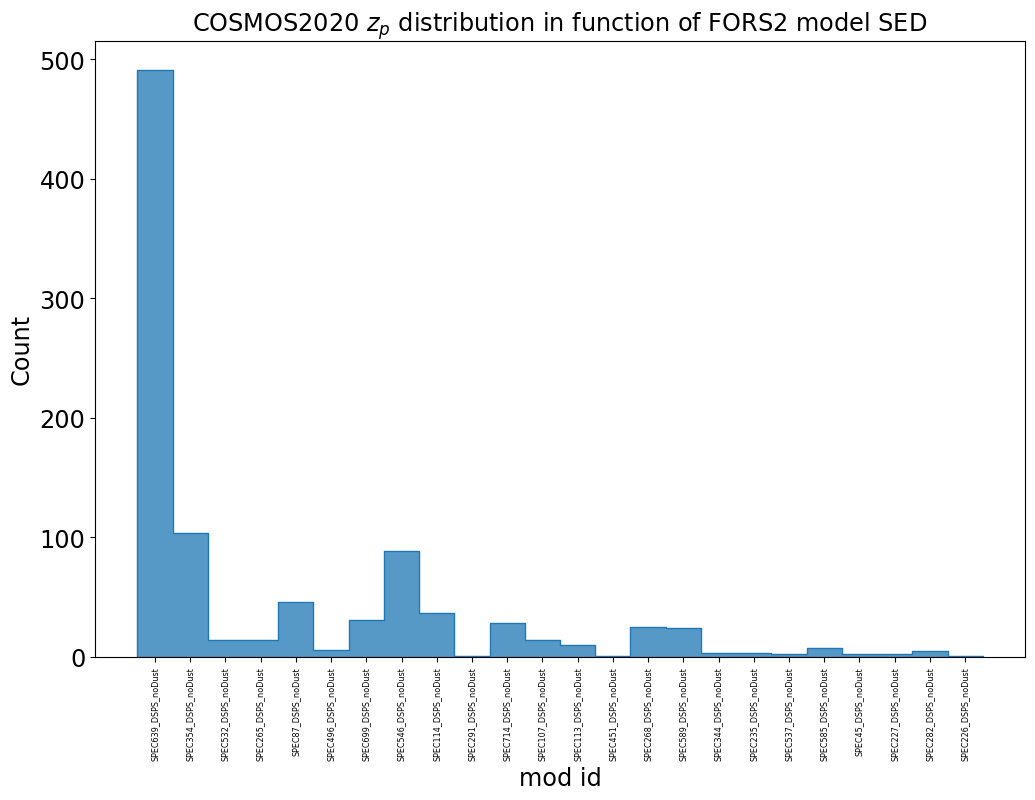

In [26]:
f, a = plt.subplots(1,1)
sns.histplot(data=df_resLePhare[df_resLePhare['chi']<200.], x='mod id',\
             stat='count', element='step', multiple='layer', discrete=True, ax=a\
            )
#sns.move_legend(a, loc='lower left', bbox_to_anchor=(1., 0.))

a.tick_params(axis='x', rotation=90, labelsize='xx-small')
a.set_title('COSMOS2020 $z_p$ distribution in function of FORS2 model SED')

Text(0.5, 1.0, 'COSMOS2020 $z_p$ distribution in function of FORS2 model SED')

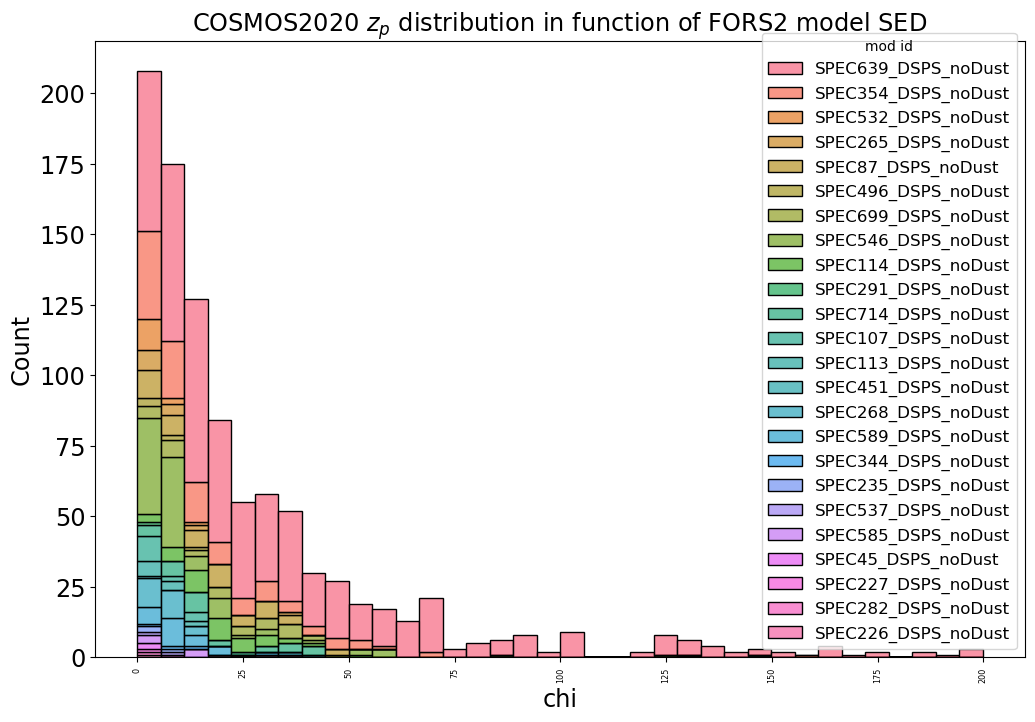

In [27]:
f, a = plt.subplots(1,1)
sns.histplot(data=df_resLePhare[df_resLePhare['chi']<200.], x='chi',\
             stat='count', element='bars', multiple='stack', hue='mod id', discrete=False, ax=a\
            )
#sns.move_legend(a, loc='lower left', bbox_to_anchor=(1., 0.))

a.tick_params(axis='x', rotation=90, labelsize='xx-small')
a.set_title('COSMOS2020 $z_p$ distribution in function of FORS2 model SED')

<AxesSubplot: xlabel='zs', ylabel='chi'>

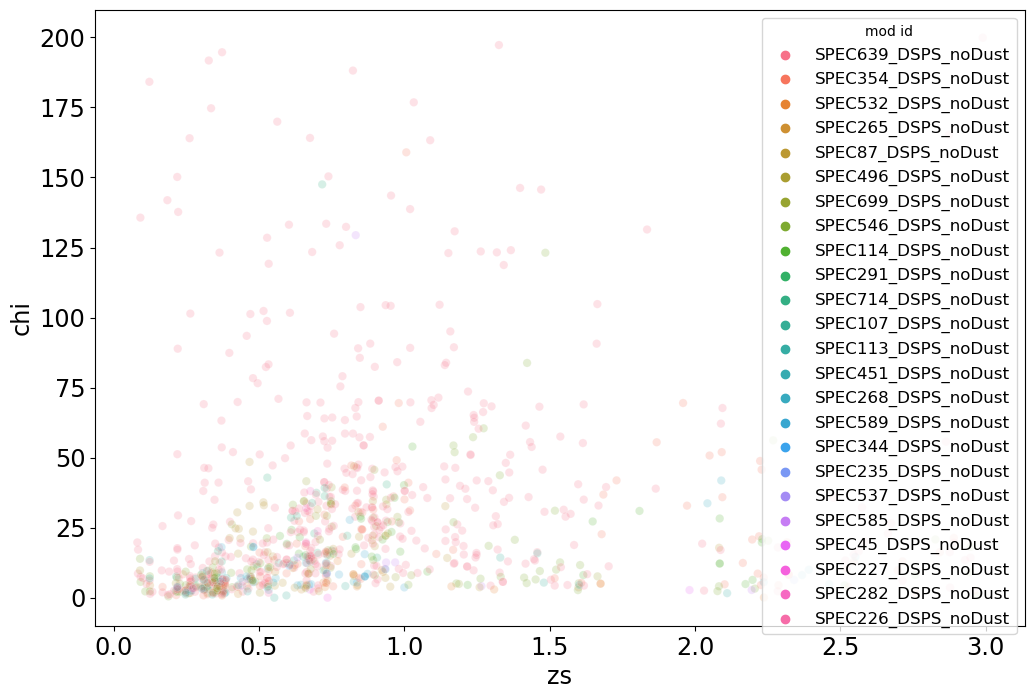

In [28]:
f, a = plt.subplots(1,1)
sns.scatterplot(data=df_resLePhare[df_resLePhare['chi']<200], x='zs', y='chi', hue='mod id', ax=a, alpha=0.2)

In [29]:
templates, counts_temp = np.unique(df_resLePhare['mod id'], return_counts=True)
templates, counts_temp

(array(['SPEC107_DSPS_noDust', 'SPEC113_DSPS_noDust',
        'SPEC114_DSPS_noDust', 'SPEC226_DSPS_noDust',
        'SPEC227_DSPS_noDust', 'SPEC235_DSPS_noDust',
        'SPEC265_DSPS_noDust', 'SPEC268_DSPS_noDust',
        'SPEC282_DSPS_noDust', 'SPEC291_DSPS_noDust',
        'SPEC344_DSPS_noDust', 'SPEC354_DSPS_noDust',
        'SPEC451_DSPS_noDust', 'SPEC45_DSPS_noDust', 'SPEC496_DSPS_noDust',
        'SPEC532_DSPS_noDust', 'SPEC537_DSPS_noDust',
        'SPEC546_DSPS_noDust', 'SPEC585_DSPS_noDust',
        'SPEC589_DSPS_noDust', 'SPEC639_DSPS_noDust',
        'SPEC699_DSPS_noDust', 'SPEC714_DSPS_noDust', 'SPEC87_DSPS_noDust'],
       dtype=object),
 array([ 14,  10,  37,   1,   2,   3,  14,  25,   5,   1,   3, 104,   1,
          2,   6,  14,   2,  89,   7,  24, 531,  31,  28,  46]))

In [30]:
counts_chis, chis = np.histogram(df_resLePhare['chi'], bins=1000)
chis, counts_chis

(array([  0.      ,   0.470967,   0.941934, ..., 470.025066, 470.496033,
        470.967   ]),
 array([ 3,  6,  7, 16, 18, 24, 17, 14, 31, 36, 19, 22, 16, 19, 18, 20, 15,
        15, 19, 13, 11, 13,  6, 10,  9, 14, 12, 13, 13,  7, 10, 11,  8, 11,
        11,  6,  8,  5,  8,  9,  5, 12,  3,  6,  8,  7, 10,  1,  4,  4,  6,
         7,  4,  4,  5,  4,  2, 10,  5,  3,  3,  8,  3,  1,  4, 10,  4,  5,
         6,  8,  5,  7,  3,  4,  5,  6,  6,  2,  3,  2,  6,  4,  4,  5,  1,
         4,  0,  5,  6,  2,  0,  2,  1,  1,  3,  1,  1,  4,  6,  3,  3,  1,
         2,  1,  1,  1,  0,  1,  5,  0,  3,  0,  0,  2,  2,  4,  0,  3,  3,
         2,  0,  3,  2,  0,  3,  0,  0,  0,  2,  1,  1,  1,  0,  2,  2,  1,
         2,  2,  1,  0,  1,  0,  0,  3,  1,  1,  3,  4,  4,  3,  1,  1,  0,
         0,  0,  0,  1,  0,  0,  0,  1,  0,  1,  0,  0,  0,  1,  1,  0,  0,
         0,  0,  0,  0,  2,  0,  2,  1,  2,  0,  0,  1,  0,  0,  0,  1,  0,
         0,  1,  3,  0,  0,  2,  0,  0,  0,  0,  0,  1,  0,  1,  1,  

(array([ 3.,  6.,  7., 16., 18., 24., 17., 14., 31., 36., 19., 22., 16.,
        19., 18., 20., 15., 15., 19., 13., 11., 13.,  6., 10.,  9., 14.,
        12., 13., 13.,  7., 10., 11.,  8., 11., 11.,  6.,  8.,  5.,  8.,
         9.,  5., 12.,  3.,  6.,  8.,  7., 10.,  1.,  4.,  4.,  6.,  7.,
         4.,  4.,  5.,  4.,  2., 10.,  5.,  3.,  3.,  8.,  3.,  1.,  4.,
        10.,  4.,  5.,  6.,  8.,  5.,  7.,  3.,  4.,  5.,  6.,  6.,  2.,
         3.,  2.,  6.,  4.,  4.,  5.,  1.,  4.,  0.,  5.,  6.,  2.,  0.,
         2.,  1.,  1.,  3.,  1.,  1.,  4.,  6.,  3.,  3.,  1.,  2.,  1.,
         1.,  1.,  0.,  1.,  5.,  0.,  3.,  0.,  0.,  2.,  2.,  4.,  0.,
         3.,  3.,  2.,  0.,  3.,  2.,  0.,  3.,  0.,  0.,  0.,  2.,  1.,
         1.,  1.,  0.,  2.,  2.,  1.,  2.,  2.,  1.,  0.,  1.,  0.,  0.,
         3.,  1.,  1.,  3.,  4.,  4.,  3.,  1.,  1.,  0.,  0.,  0.,  0.,
         1.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  1.,  1.,  0.,
         0.,  0.,  0.,  0.,  0.,  2.,  0.,  2.,  1.

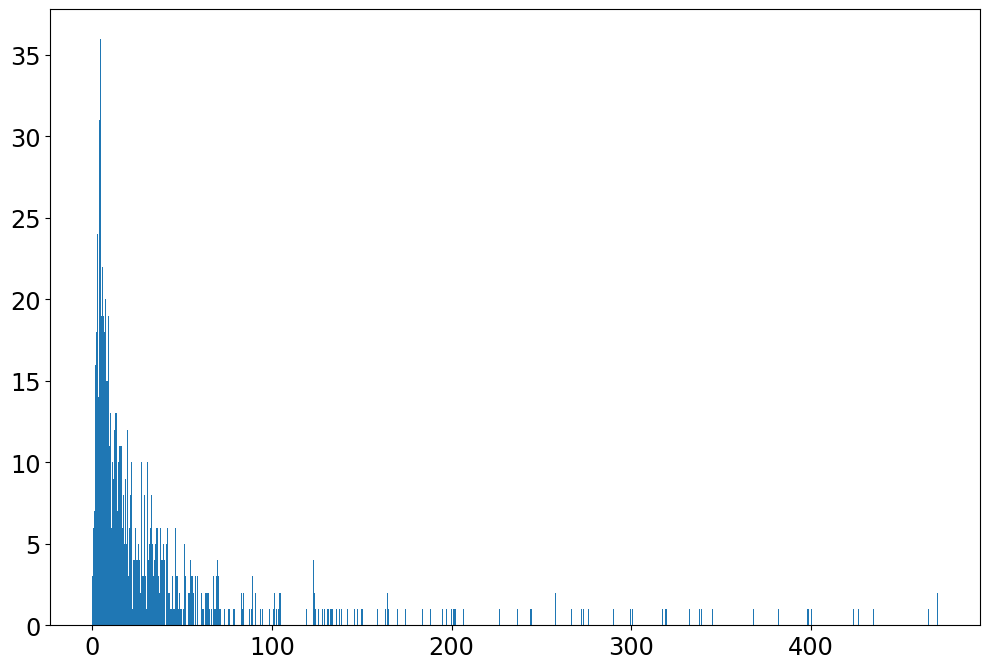

In [31]:
plt.hist(df_resLePhare['chi'], bins=1000)

960


Text(0, 0.5, '$\\chi^2$')

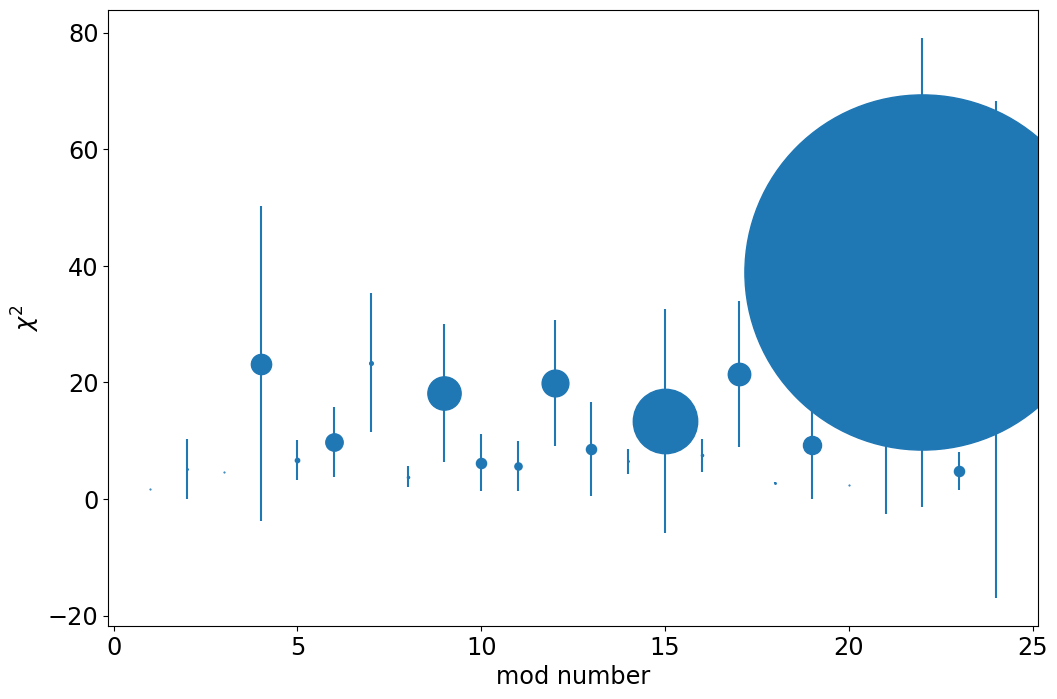

In [32]:
_df = df_resLePhare[df_resLePhare['chi']<200]
NMAX = len(_df.index)
print(NMAX)
for modid in np.unique(_df['mod id'].values):  
    chi_arr = np.array(_df[_df['mod id']==modid]['chi'].values)
    nb_hits = len(chi_arr)
    mean_chi = np.average(chi_arr)
    sig_chi = np.std(chi_arr)
    plt.errorbar(_df[_df['mod id']==modid]['mod'].values[0], mean_chi, yerr=sig_chi,\
                 fmt='.', barsabove=True, mfc='tab:blue', mec='tab:blue', ms=nb_hits/NMAX*100*10, ecolor='tab:blue',\
                )
plt.xlabel('mod number')
plt.ylabel('$\chi^2$')

## Load the z_phot results

In [33]:
zphot_res_name = f"df_{'_'.join(res_file_name.split('_')[:-1])}.pkl"
print(zphot_res_name)

df_zphot2020_fors2DSPS_noDustV1_prevEtCal_EmuLP.pkl


In [34]:
df_zphot = pd.read_pickle(zphot_res_name)
df_zphot

,Id,zp,zl68,zu68,zml,zmll68,zmlu68,chi,mod,law,...,zs_Outlier,zp_Outlier,zs_Insider,zp_Insider,Path to mod,mod id,Path to mod2,mod2 id,SEL_MAG,SEL_ZS
0,362,0.5846,0.5731,0.5974,0.5948,0.5781,0.6192,58.76700,22.0,0.0,...,NaN,NaN,0.6636,0.5846,/home/joseph/PhotoZ_PhD/LEPHARE/sed/GAL/FORS2_...,SPEC639_DSPS_noDust,n/a,n/a,15.0<=mag<22.5,0.5<=z-spec<1.0
1,8353,0.2850,0.2738,0.2911,0.2842,0.2708,0.2970,7.20848,22.0,0.0,...,NaN,NaN,0.2819,0.2850,/home/joseph/PhotoZ_PhD/LEPHARE/sed/GAL/FORS2_...,SPEC639_DSPS_noDust,n/a,n/a,15.0<=mag<22.5,0.0<=z-spec<0.5
2,7547,0.1546,0.1279,0.1846,0.1554,0.1308,0.1786,21.70310,22.0,0.0,...,NaN,NaN,0.2215,0.1546,/home/joseph/PhotoZ_PhD/LEPHARE/sed/GAL/FORS2_...,SPEC639_DSPS_noDust,n/a,n/a,15.0<=mag<22.5,0.0<=z-spec<0.5
3,10402,0.5389,0.5230,0.5569,0.5463,0.5264,0.5739,5.22882,15.0,1.0,...,NaN,NaN,0.6595,0.5389,/home/joseph/PhotoZ_PhD/LEPHARE/sed/GAL/FORS2_...,SPEC546_DSPS_noDust,n/a,n/a,15.0<=mag<22.5,0.5<=z-spec<1.0
4,12425,1.5840,1.4910,1.6377,1.5861,1.5373,1.6251,5.73898,19.0,1.0,...,1.0201,1.584,NaN,NaN,/home/joseph/PhotoZ_PhD/LEPHARE/sed/GAL/FORS2_...,SPEC268_DSPS_noDust,n/a,n/a,22.5<=mag<23.5,1.0<=z-spec<1.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,5756,2.4920,2.4593,2.5225,2.4824,2.4465,2.5155,5.93328,21.0,0.0,...,NaN,NaN,2.6639,2.4920,/home/joseph/PhotoZ_PhD/LEPHARE/sed/GAL/FORS2_...,SPEC354_DSPS_noDust,/home/joseph/PhotoZ_PhD/LEPHARE/sed/GAL/FORS2_...,SPEC585_DSPS_noDust,23.5<=mag<25,2.5<=z-spec<3.0
996,16455,0.6664,0.5662,0.6758,0.6377,0.5865,0.6646,6.05954,4.0,1.0,...,NaN,NaN,0.7336,0.6664,/home/joseph/PhotoZ_PhD/LEPHARE/sed/GAL/FORS2_...,SPEC714_DSPS_noDust,n/a,n/a,15.0<=mag<22.5,0.5<=z-spec<1.0
997,13692,0.7109,0.7027,0.7204,0.7160,0.7029,0.7319,11.88490,22.0,0.0,...,NaN,NaN,0.9258,0.7109,/home/joseph/PhotoZ_PhD/LEPHARE/sed/GAL/FORS2_...,SPEC639_DSPS_noDust,n/a,n/a,15.0<=mag<22.5,0.5<=z-spec<1.0
998,3751,0.7260,0.7071,0.7425,0.7173,0.7028,0.7355,12.19150,22.0,1.0,...,NaN,NaN,0.8700,0.7260,/home/joseph/PhotoZ_PhD/LEPHARE/sed/GAL/FORS2_...,SPEC639_DSPS_noDust,n/a,n/a,15.0<=mag<22.5,0.5<=z-spec<1.0


In [35]:
df_resLePhare

,Id,zp,zl68,zu68,zml,zmll68,zmlu68,chi,mod,law,...,scale,nbFilt,context,zs,Path to mod,mod id,Path to mod2,mod2 id,SEL_MAG,SEL_ZS
0,362,0.6636,0.66,0.66,0.66,0.6532,0.6668,69.73750,22.0,0.0,...,31.18660,7.0,0.0,0.6636,/home/joseph/PhotoZ_PhD/LEPHARE/sed/GAL/FORS2_...,SPEC639_DSPS_noDust,n/a,n/a,15.0<=mag<22.5,0.5<=z-spec<1.0
1,8353,0.2819,0.28,0.28,0.28,0.2732,0.2868,7.24336,22.0,0.0,...,58.02010,7.0,0.0,0.2819,/home/joseph/PhotoZ_PhD/LEPHARE/sed/GAL/FORS2_...,SPEC639_DSPS_noDust,n/a,n/a,15.0<=mag<22.5,0.0<=z-spec<0.5
2,7547,0.2215,0.22,0.22,0.22,0.2132,0.2268,29.38850,22.0,0.0,...,7.91476,7.0,0.0,0.2215,/home/joseph/PhotoZ_PhD/LEPHARE/sed/GAL/FORS2_...,SPEC639_DSPS_noDust,n/a,n/a,15.0<=mag<22.5,0.0<=z-spec<0.5
3,10402,0.6595,0.66,0.66,0.66,0.6532,0.6668,18.39740,21.0,1.0,...,83.70940,7.0,0.0,0.6595,/home/joseph/PhotoZ_PhD/LEPHARE/sed/GAL/FORS2_...,SPEC354_DSPS_noDust,n/a,n/a,15.0<=mag<22.5,0.5<=z-spec<1.0
4,12425,1.0200,1.02,1.02,1.02,1.0132,1.0268,89.17320,22.0,1.0,...,55.23120,7.0,0.0,1.0201,/home/joseph/PhotoZ_PhD/LEPHARE/sed/GAL/FORS2_...,SPEC639_DSPS_noDust,n/a,n/a,22.5<=mag<23.5,1.0<=z-spec<1.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,5756,2.6640,2.66,2.66,2.66,2.6532,2.6668,22.88850,22.0,1.0,...,313.22900,7.0,0.0,2.6639,/home/joseph/PhotoZ_PhD/LEPHARE/sed/GAL/FORS2_...,SPEC639_DSPS_noDust,n/a,n/a,23.5<=mag<25,2.5<=z-spec<3.0
996,16455,0.7336,0.73,0.73,0.73,0.7232,0.7368,29.19320,17.0,1.0,...,84.56080,7.0,0.0,0.7336,/home/joseph/PhotoZ_PhD/LEPHARE/sed/GAL/FORS2_...,SPEC699_DSPS_noDust,n/a,n/a,15.0<=mag<22.5,0.5<=z-spec<1.0
997,13692,0.9258,0.93,0.93,0.93,0.9232,0.9368,61.03580,21.0,1.0,...,335.89100,7.0,0.0,0.9258,/home/joseph/PhotoZ_PhD/LEPHARE/sed/GAL/FORS2_...,SPEC354_DSPS_noDust,n/a,n/a,15.0<=mag<22.5,0.5<=z-spec<1.0
998,3751,0.8700,0.87,0.87,0.87,0.8632,0.8768,32.25500,22.0,1.0,...,93.74040,7.0,0.0,0.8700,/home/joseph/PhotoZ_PhD/LEPHARE/sed/GAL/FORS2_...,SPEC639_DSPS_noDust,n/a,n/a,15.0<=mag<22.5,0.5<=z-spec<1.0


In [36]:
from pysankey import sankey

<AxesSubplot: >

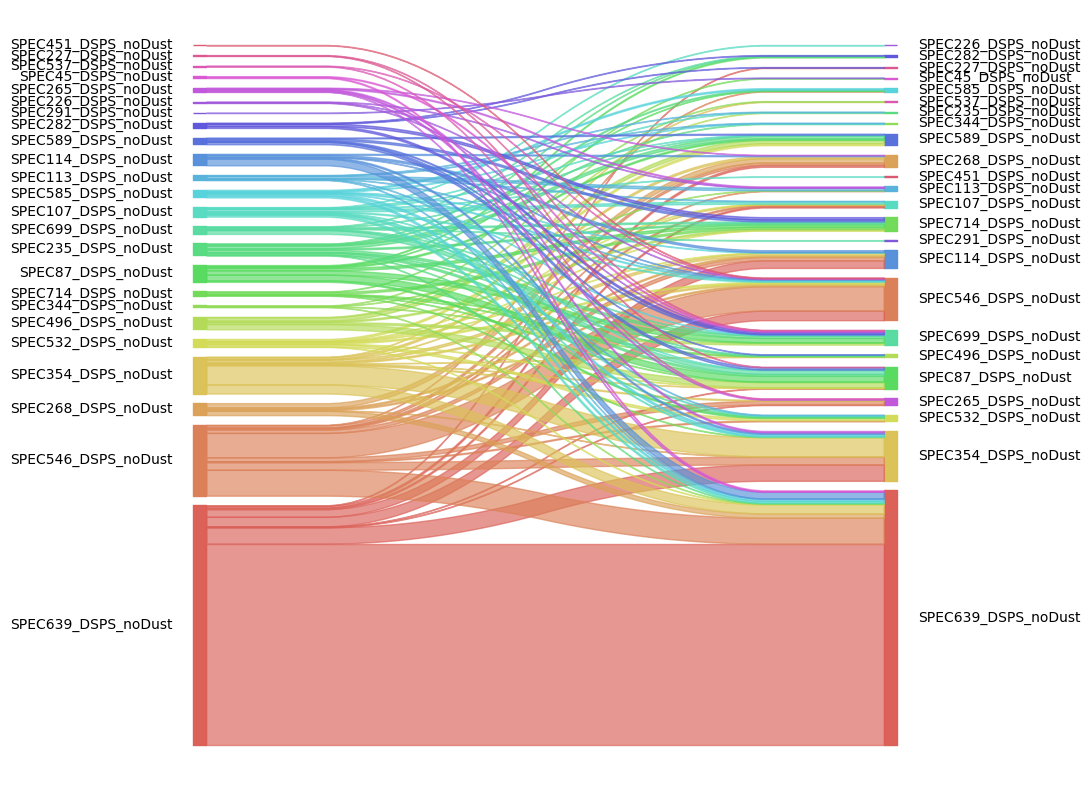

In [37]:
f,a = plt.subplots(1,1, figsize=(10,10))
sankey(df_zphot['mod id'], df_resLePhare['mod id'], fontsize=10, ax=a)

In [40]:
outl_subdf = df_zphot[df_zphot['Outlier']]
outl_subdf_zfix = df_resLePhare[df_zphot['Outlier']]

<AxesSubplot: >

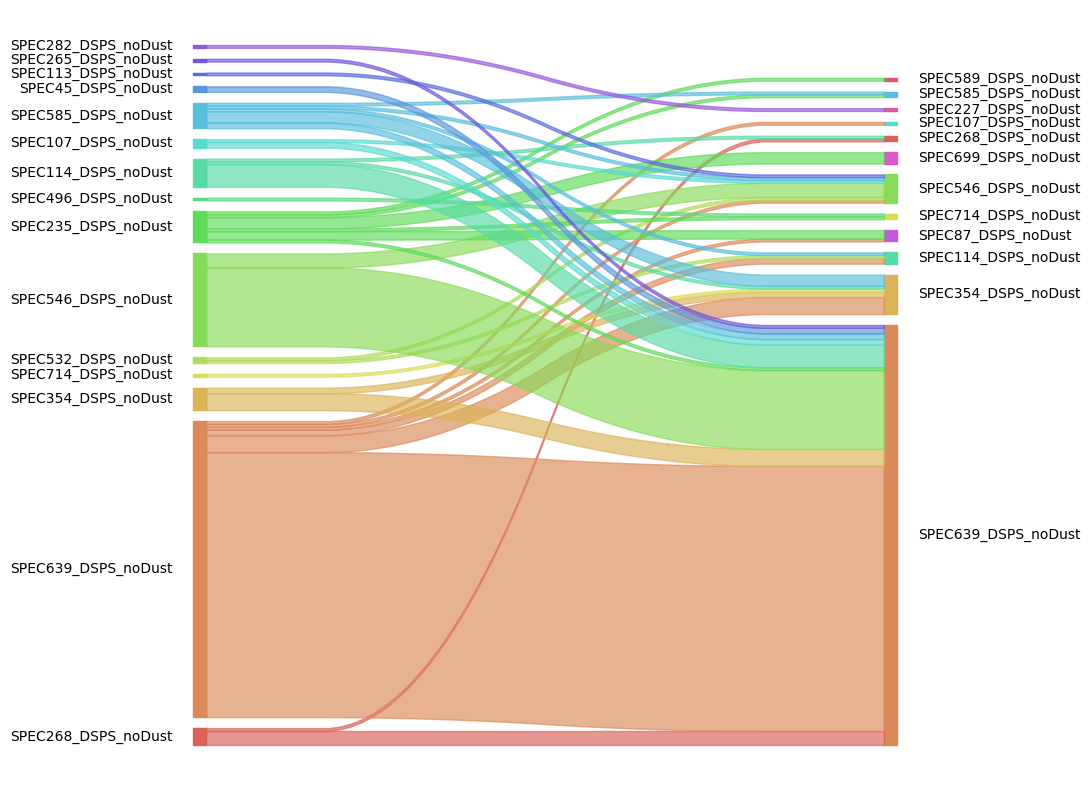

In [41]:
f,a = plt.subplots(1,1, figsize=(10,10))
sankey(outl_subdf['mod id'], outl_subdf_zfix['mod id'], fontsize=10, ax=a)